# Compute P-/S-wave travel Times

In this notebook, we compute the table of P-/S-wave travel times from a 3D grid of potential source locations to every seismic station. This travel time table is necessary for backprojection and for earthquake location with `NLLoc`.

This tutorial uses the `pykonal` package to compute travel times in a given velocity model (see `pykonal` documentation at [https://github.com/malcolmw/pykonal](https://github.com/malcolmw/pykonal)). Please acknowledge [White et al. (2020)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/91/4/2378/586804/PyKonal-A-Python-Package-for-Solving-the-Eikonal?redirectedFrom=fulltext) if using `pykonal`.

In [1]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import h5py as h5
import numpy as np
import pykonal
import pandas as pd
import sys


from BPMF import NLLoc_utils
from scipy.interpolate import interp1d, LinearNDInterpolator
from tqdm import tqdm

## Load station metadata

In [2]:
NETWORK_FILENAME = "network.csv"
TT_FILENAME = "tts.h5"

In [3]:
# read network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Read the velocity model from Karabulut et al. 2011

In [4]:
# we assume that you are running this notebook from Seismic_BPMF/notebooks/ and the velocity model
# is stored at Seismic_BPMF/data/
FILEPATH_VEL_MODEL = os.path.join(os.pardir, "data", "velocity_model_Karabulut2011.csv")

We read the velocity model with `pandas`. Not all columns of the csv files are necessary for our purpose. The velocity model is a 1D layered model and the `depth` column gives the top of each layer in meters (positive downward). The `P` and `S` columns are the wave velocities in m/s.

In [5]:
# read the velocity model with pandas
velocity_model = pd.read_csv(
    FILEPATH_VEL_MODEL, 
    usecols=[1, 2, 4],
    names=["depth", "P", "S"],
    skiprows=1,
    )
velocity_model.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
depth,-2000.0,0.0,1000.0,2000.0,3000.0,4000.0,5000.0,6000.0,8000.0,10000.0,12000.0,14000.0,15000.0,20000.0,22000.0,25000.0,32000.0,77000.0
P,2900.0,3000.0,5600.0,5700.0,5800.0,5900.0,5950.0,6050.0,6100.0,6150.0,6200.0,6250.0,6300.0,6400.0,6500.0,6700.0,8000.0,8045.0
S,1670.0,1900.0,3150.0,3210.0,3260.0,3410.0,3420.0,3440.0,3480.0,3560.0,3590.0,3610.0,3630.0,3660.0,3780.0,3850.0,4650.0,4650.0


## Build a 3D Grid of P-/S-wave Velocities

Even though the model used here is a 1D model, `pykonal` works with a 3D model. Therefore, we first need to define the velocity model on a 3D spatial grid.

In [6]:
# define constant to go from degrees to radians
DEG_TO_RAD = np.pi / 180.
# define the geographical extent of the 3D grid
LON_MIN_DEG = 30.20
LON_MAX_DEG = 30.45
LAT_MIN_DEG = 40.60
LAT_MAX_DEG = 40.80
DEP_MIN_KM = -2.0
DEP_MAX_KM = 30.
# define the grid spacing
D_LON_DEG = 0.01 
D_LAT_DEG = 0.01
D_LON_RAD = D_LON_DEG * DEG_TO_RAD
D_LAT_RAD = D_LAT_DEG * DEG_TO_RAD
D_DEP_KM = 0.5

All stations must be located within the travel-time grid, otherwise PyKonal returns `inf` travel times for those stations that are outside the grid.

In [7]:
# if nothing happens here, it means that everything is alright
for s in range(net.n_stations):
    if (net.longitude[s] < LON_MIN_DEG) or (net.longitude[s] > LON_MAX_DEG):
        print(f"The longitude of station {net.stations[s]} is outside the grid! Make your grid bigger.")
    if (net.latitude[s] < LAT_MIN_DEG) or (net.latitude[s] > LAT_MAX_DEG):
        print(f"The latitude of station {net.stations[s]} is outside the grid! Make your grid bigger.")
    if (net.depth[s] < DEP_MIN_KM) or (net.depth[s] > DEP_MAX_KM):
        print(f"The depth of station {net.stations[s]} is outside the grid! Make your grid bigger.")

In [8]:
# we will be using pykonal in spherical coordinates with radial coordinates (depth) in km
# therefore, we first convert all meters in kilometers
velocity_model["depth"] /= 1000.0
velocity_model["P"] /= 1000.0
velocity_model["S"] /= 1000.0

In [9]:
# to expand the 1D layered velocity model onto a 3D grid,
# we build an interpolator that gives the velocity at any point in depth
# to preserve the layered structure in the interpolated model, we need to
# add new rows to the 1D model to keep the velocity discontinuities

# new depths just below the existing depths
new_depths = velocity_model["depth"][1:] - 0.00001
# P-wave velocity interpolator
new_vP = velocity_model["P"][:-1]
interpolator_P = interp1d(
    np.hstack((velocity_model["depth"], new_depths)),
    np.hstack((velocity_model["P"], new_vP)),
)
# S-wave velocity interpolator
new_vS = velocity_model["S"][:-1]
interpolator_S = interp1d(
    np.hstack((velocity_model["depth"], new_depths)),
    np.hstack((velocity_model["S"], new_vS)),
)

The spherical coordinate system used by `pykonal` specifies a point position with $(r, \theta, \varphi)$:
- $r$: Distance from center or Earth in km (= decreasing depth).
- $\theta$: Polar angle in radians (= co-latitude or, equivalently, decreasing latitude).
- $\varphi$: Azimuthal angle in radians (= longitude).

Thus, the 3D grid must be built such that $r$, $\theta$ and $\varphi$ increase with increasing index. Axis 0 is decreasing depth, axis 1 is decreasing latitude and axis 2 is increasing longitude.

In [10]:
# make sure the user-specified ends of the grid are included in the arange vectors
longitudes = np.arange(LON_MIN_DEG, LON_MAX_DEG+D_LON_DEG/2., D_LON_DEG)
latitudes = np.arange(LAT_MAX_DEG, LAT_MIN_DEG-D_LAT_DEG/2., -D_LAT_DEG)
depths = np.arange(DEP_MAX_KM, DEP_MIN_KM-D_DEP_KM/2., -D_DEP_KM)

print("Increasing longitudes: ", longitudes)
print("Decreasing latitudes: ", latitudes)
print("Decreasing depths: ", depths)

# get the number of points in each direction
n_longitudes = len(longitudes)
n_latitudes = len(latitudes)
n_depths = len(depths)

Increasing longitudes:  [30.2  30.21 30.22 30.23 30.24 30.25 30.26 30.27 30.28 30.29 30.3  30.31
 30.32 30.33 30.34 30.35 30.36 30.37 30.38 30.39 30.4  30.41 30.42 30.43
 30.44 30.45]
Decreasing latitudes:  [40.8  40.79 40.78 40.77 40.76 40.75 40.74 40.73 40.72 40.71 40.7  40.69
 40.68 40.67 40.66 40.65 40.64 40.63 40.62 40.61 40.6 ]
Decreasing depths:  [30.  29.5 29.  28.5 28.  27.5 27.  26.5 26.  25.5 25.  24.5 24.  23.5
 23.  22.5 22.  21.5 21.  20.5 20.  19.5 19.  18.5 18.  17.5 17.  16.5
 16.  15.5 15.  14.5 14.  13.5 13.  12.5 12.  11.5 11.  10.5 10.   9.5
  9.   8.5  8.   7.5  7.   6.5  6.   5.5  5.   4.5  4.   3.5  3.   2.5
  2.   1.5  1.   0.5  0.  -0.5 -1.  -1.5 -2. ]


In [11]:
# use the previously defined interpolators to compute the P-/S-wave velocity
# at each point of the 3D spherical coordinate grid defined by depths, latitudes, longitudes (see above cell)
vP_grid = np.zeros((n_depths, n_latitudes, n_longitudes), dtype=np.float32)
vS_grid = np.zeros((n_depths, n_latitudes, n_longitudes), dtype=np.float32)
for i in range(n_depths):
    vP_grid[i, :, :] = interpolator_P(depths[i])
    vS_grid[i, :, :] = interpolator_S(depths[i])

depths_g, latitudes_g, longitudes_g = np.meshgrid(
    depths, latitudes, longitudes, indexing="ij"
)

# keep velocities and grid point coordinates in a dictionary for later use
grid = {}
grid["vP"] = vP_grid
grid["vS"] = vS_grid
grid["longitude"] = longitudes_g
grid["latitude"] = latitudes_g
grid["depth"] = depths_g

The 3D grid is ready! This piece of code can easily be adapted for using a 2D or 3D input velocity model. Keep in mind that, in most cases, even a 3D velocity model will have to be re-ordered to satisfy `pykonal` conventions.

## Compute the P-/S-wave travel times

In [12]:
# define the origin of our grid for pykonal
# the origin of the grid is the point with lowest (r, theta, phi)
r_min, theta_min, phi_min = pykonal.transformations.geo2sph(
    [grid["latitude"].max(), grid["longitude"].min(), grid["depth"].max()]
)
print(
    "Min radius: {:.0f} km, min co-latitude: {:.2f} rad, min azimuthal angle: {:.2f} rad".format(
        r_min, theta_min, phi_min
    )
)


Min radius: 6341 km, min co-latitude: 0.86 rad, min azimuthal angle: 0.53 rad


In [13]:
# store travel times in a dictionary
tts = {"tt_P": {}, "tt_S": {}}
for s, network_sta in tqdm(enumerate(net.stations), desc="Computing travel times"):
    for phase in ["P", "S"]:
        # initialize travel time arrays
        tts[f"tt_{phase}"][network_sta] = np.zeros(
            grid[f"v{phase}"].shape, dtype=np.float32
        )

        # initialize the Eikonal equation solver
        solver = pykonal.solver.PointSourceSolver(coord_sys="spherical")
        # define the computational grid so that it matches exactly
        # the grid on which we have expanded the velocity model
        solver.velocity.min_coords = r_min, theta_min, phi_min
        solver.velocity.node_intervals = D_DEP_KM, D_LAT_RAD, D_LON_RAD
        solver.velocity.npts = n_depths, n_latitudes, n_longitudes
        solver.velocity.values = grid[f"v{phase}"]

        # we take the station as the seismic source to compute the
        # travel times to all points of the grid
        source_latitude = net.latitude[s]
        source_longitude = net.longitude[s]
        source_depth = net.depth[s]
        # convert the geographical coordinates to spherical coordinates
        r_source, theta_source, lbd_source = pykonal.transformations.geo2sph(
            [source_latitude, source_longitude, source_depth]
        )
        solver.src_loc = np.array([r_source, theta_source, lbd_source])

        # solve the Eikonal equation
        solver.solve()

        tts[f"tt_{phase}"][network_sta] = solver.tt.values[...]

# store source coordinates in tts:
tts["source_coordinates"] = {}
src_coords = pykonal.transformations.sph2geo(solver.velocity.nodes)
tts["source_coordinates"]["latitude"] = src_coords[..., 0]
tts["source_coordinates"]["longitude"] = src_coords[..., 1]
tts["source_coordinates"]["depth"] = src_coords[..., 2]


Computing travel times: 0it [00:00, ?it/s]

Computing travel times: 8it [00:08,  1.01s/it]


## Store travel time table for backprojection

In [14]:
# write travel-times in hdf5 file
with h5.File(os.path.join(BPMF.cfg.MOVEOUTS_PATH, TT_FILENAME), mode="w") as f:
    for key1 in tts.keys():
        f.create_group(key1)
        for key2 in tts[key1].keys():
            f[key1].create_dataset(key2, data=tts[key1][key2], compression="gzip")

## Store travel time tables for `NLLoc`

We write the travel time tables in an adequate format for `NLLoc` using the utility functions from `BPMF.NLLoc_utils`.

In [15]:
# use the functions from ``
# save travel time tables for NLLoc
longitude, latitude, depth, tts_nlloc = BPMF.NLLoc_utils.load_pykonal_tts(
    TT_FILENAME, path=BPMF.cfg.MOVEOUTS_PATH
)

BPMF.NLLoc_utils.write_NLLoc_inputs(
    longitude,
    latitude,
    depth,
    tts_nlloc,
    net,
    output_path=BPMF.cfg.NLLOC_INPUT_PATH,
    basename=BPMF.cfg.NLLOC_BASENAME,
)


The origin of the grid is: 30.2000, 40.6000, -2.000km
Longitude spacing: 0.010deg
Latitude spacing: 0.010deg
Depth spacing: 0.500km
Station DD06
--- Phase P
--- Phase S
Station DC08
--- Phase P
--- Phase S
Station DE08
--- Phase P
--- Phase S
Station SPNC
--- Phase P
--- Phase S
Station DC06
--- Phase P
--- Phase S
Station SAUV
--- Phase P
--- Phase S
Station DC07
--- Phase P
--- Phase S
Station DE07
--- Phase P
--- Phase S
Done!


## Plot the travel time field for a given station

In [16]:
import cartopy as ctp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.interpolate import interpn

In [17]:
# define map parameters

# define inset extent
LAT_MIN_INSET, LAT_MAX_INSET = 36.00, 42.00
LON_MIN_INSET, LON_MAX_INSET = 22.00, 36.00
# define projections
data_coords = ctp.crs.PlateCarree()
projection = ctp.crs.Mercator(
    central_longitude=(LON_MIN_DEG + LON_MAX_DEG) / 2.0,
    min_latitude=LAT_MIN_DEG,
    max_latitude=LAT_MAX_DEG,
)
projection_inset = ctp.crs.Mercator(
    central_longitude=(LON_MIN_INSET + LON_MAX_INSET) / 2.0,
    min_latitude=LAT_MIN_INSET,
    max_latitude=LAT_MAX_INSET,
)

source_coords = {}
source_coords["longitude"] = longitudes_g
source_coords["latitude"] = latitudes_g
source_coords["depth"] = depths_g

shape_3D = (n_depths, n_latitudes, n_longitudes)

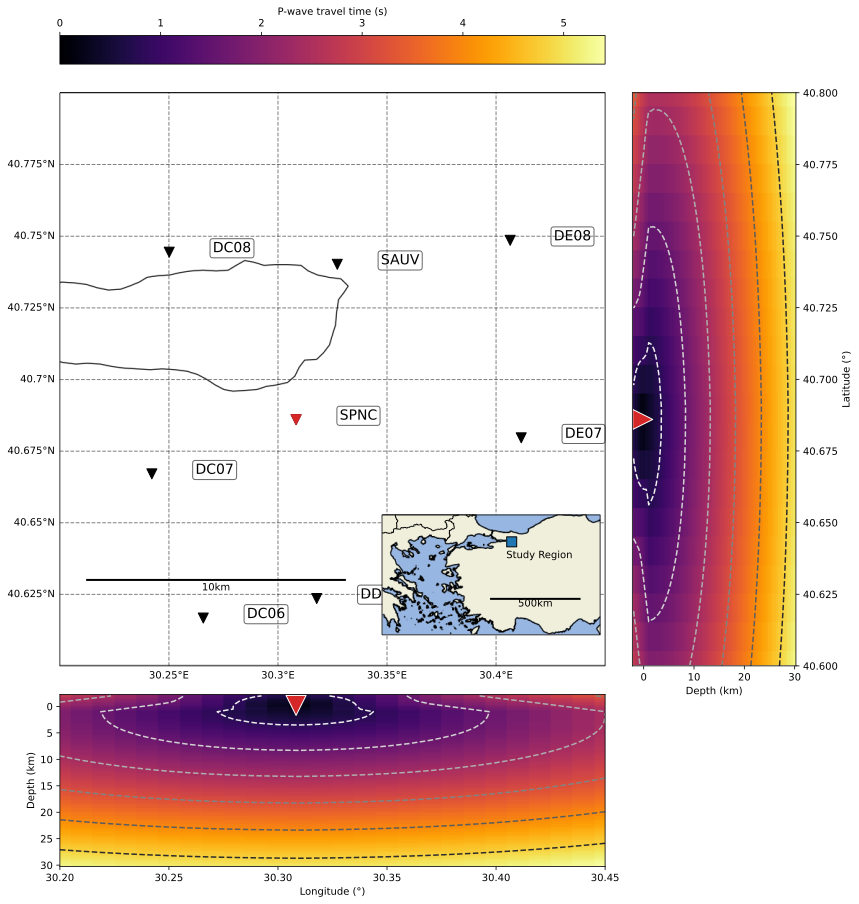

In [18]:
%config InlineBackend.figure_formats = ['svg']

# plot map
fig = plt.figure("map_stations_grid", figsize=(15, 15))
ax = fig.add_subplot(111, projection=projection)
ax.set_rasterization_zorder(1.0)
ax.set_extent([LON_MIN_DEG, LON_MAX_DEG, LAT_MIN_DEG, LAT_MAX_DEG])

ax = BPMF.plotting_utils.initialize_map(
    [LON_MIN_DEG, LON_MAX_DEG],
    [LAT_MIN_DEG, LAT_MAX_DEG],
    map_axis=ax,
    seismic_stations=net.metadata,
)

BPMF.plotting_utils.add_scale_bar(ax, 0.05, 0.15, 10.0, projection)

# plot inset map
axins = inset_axes(
    ax,
    width="40%",
    height="30%",
    loc="lower right",
    axes_class=ctp.mpl.geoaxes.GeoAxes,
    axes_kwargs=dict(map_projection=projection_inset),
)
axins.set_rasterization_zorder(1.5)
axins.set_extent(
    [LON_MIN_INSET, LON_MAX_INSET, LAT_MIN_INSET, LAT_MAX_INSET], crs=data_coords
)
# study_region = geometry.box(minx=lon_min, maxx=lon_max, miny=lat_min, maxy=lat_max)
# axins.add_geometries([study_region], crs=data_coords, edgecolor="k", facecolor="C0")
axins.plot(
    (LON_MIN_DEG + LON_MAX_DEG) / 2.0,
    (LAT_MIN_DEG + LAT_MAX_DEG) / 2.0,
    marker="s",
    color="C0",
    markersize=10,
    markeredgecolor="k",
    transform=data_coords,
)
axins.text(
    (LON_MIN_DEG + LON_MAX_DEG) / 2.0 - 0.35,
    (LAT_MIN_DEG + LAT_MAX_DEG) / 2.0 - 0.8,
    "Study Region",
    transform=data_coords,
)

axins.add_feature(ctp.feature.BORDERS)
axins.add_feature(ctp.feature.LAND)
axins.add_feature(ctp.feature.OCEAN)
axins.add_feature(ctp.feature.GSHHSFeature(scale="full", levels=[1], zorder=0.49))
BPMF.plotting_utils.add_scale_bar(axins, 0.50, 0.30, 500.0, projection_inset)

# -----------------------------------------------
#     add side axes for slices of the travel time field
divider = make_axes_locatable(ax)

cs_lon = divider.append_axes("bottom", size="30%", pad="5%", axes_class=plt.Axes)
cs_lat = divider.append_axes("right", size="30%", pad="5%", axes_class=plt.Axes)
cax = divider.append_axes("top", size="5%", pad="5%", axes_class=plt.Axes)


def cut_through(station_code, lon_spacing=0.1, lat_spacing=0.1, cm="inferno"):
    lon_sta = net.metadata.loc[station_code].longitude
    lat_sta = net.metadata.loc[station_code].latitude
    elv_sta = net.metadata.loc[station_code].elevation_m
    station_code = net.metadata.loc[station_code].stations
    # depth = np.unique(source_coords["depth"])
    # longitude = np.unique(source_coords["longitude"])
    # latitude = np.unique(source_coords["latitude"])
    # plot station in different color on map
    ax.scatter(lon_sta, lat_sta, s=100, marker="v", color="C3", transform=data_coords)
    # find closest slice in longitude
    idx_lon = np.abs(lon_sta - source_coords["longitude"][0, 0, :]).argmin()
    # find closest slice in latitude
    idx_lat = np.abs(lat_sta - source_coords["latitude"][0, :, 0]).argmin()
    # plot travel-time field
    cs_lon.clear()
    cs_lat.clear()
    # longitudinal slice
    slice_lon = np.index_exp[:, idx_lat, :]
    new_coords_slice_lon = np.stack(
        [
            source_coords["depth"][slice_lon].flatten(),
            lat_sta
            * np.ones(source_coords["longitude"][slice_lon].size, dtype=np.float32),
            source_coords["longitude"][slice_lon].flatten(),
        ],
        axis=1,
    )
    # interpn is fast but not very flexible: it builds a grid with strictly increasing coordinates
    # whereas the travel-times are given with decreasing depth and latitude because these
    # correspond to increasing radius and colatitude in spherical coordinates
    tt_P_slice_lon = interpn(
        (
            np.unique(source_coords["depth"]),
            np.unique(source_coords["latitude"]),
            np.unique(source_coords["longitude"]),
        ),
        tts["tt_P"][station_code].reshape(shape_3D)[::-1, ::-1, :],
        new_coords_slice_lon,
    ).reshape(source_coords["longitude"][slice_lon].shape)
    # latitudinal slice
    slice_lat = np.index_exp[:, :, idx_lon]
    new_coords_slice_lat = np.stack(
        [
            source_coords["depth"][slice_lat].flatten(),
            source_coords["latitude"][slice_lat].flatten(),
            lon_sta
            * np.ones(source_coords["longitude"][slice_lat].size, dtype=np.float32),
        ],
        axis=1,
    )
    tt_P_slice_lat = interpn(
        (
            np.unique(source_coords["depth"]),
            np.unique(source_coords["latitude"]),
            np.unique(source_coords["longitude"]),
        ),
        tts["tt_P"][station_code].reshape(shape_3D)[::-1, ::-1, :],
        new_coords_slice_lat,
    ).reshape(source_coords["longitude"][slice_lat].shape)
    # define tt color scale
    cnorm = Normalize(vmin=0.0, vmax=max(tt_P_slice_lon.max(), tt_P_slice_lat.max()))
    scalar_map = ScalarMappable(norm=cnorm, cmap=cm)
    # plot slices
    cs_lon.pcolormesh(
        source_coords["longitude"][slice_lon],
        source_coords["depth"][slice_lon],
        tt_P_slice_lon,
        cmap=cm,
        vmin=cnorm.vmin,
        vmax=cnorm.vmax,
        rasterized=True,
    )
    cs_lon.contour(
        source_coords["longitude"][slice_lon],
        source_coords["depth"][slice_lon],
        tt_P_slice_lon,
        cmap="Greys",
        linestyles="--"
    )
    cs_lat.pcolormesh(
        source_coords["depth"][slice_lat],
        source_coords["latitude"][slice_lat],
        tt_P_slice_lat,
        cmap=cm,
        vmin=cnorm.vmin,
        vmax=cnorm.vmax,
        rasterized=True,
    )
    cs_lat.contour(
        source_coords["depth"][slice_lat],
        source_coords["latitude"][slice_lat],
        tt_P_slice_lat,
        cmap="Greys",
        linestyles="--"
    )
    
    
    # format axis labels
    cs_lon.invert_yaxis()
    cs_lat.yaxis.set_label_position("right")
    cs_lat.yaxis.tick_right()
    cs_lon.set_ylabel("Depth (km)")
    cs_lon.set_xlabel("Longitude (" "\u00b0" ")")
    cs_lat.set_xlabel("Depth (km)")
    cs_lat.set_ylabel("Latitude (" "\u00b0" ")")
    # add station symbols
    cs_lon.plot(
        lon_sta,
        -elv_sta / 1000.0,
        marker="v",
        color="C3",
        markeredgecolor="white",
        markersize=20,
    )
    cs_lat.plot(
        -elv_sta / 1000.0,
        lat_sta,
        marker=">",
        color="C3",
        markeredgecolor="white",
        markersize=20,
    )

    cs_lon.set_xlim(LON_MIN_DEG, LON_MAX_DEG)
    cs_lat.set_ylim(LAT_MIN_DEG, LAT_MAX_DEG)

    plt.colorbar(
        scalar_map, cax=cax, label="P-wave travel time (s)", orientation="horizontal"
    )
    cax.xaxis.set_label_position("top")
    cax.xaxis.tick_top()


cut_through("SPNC")


## Bonus: Do you need a downsampled grid for efficient earthquake detection (backprojection)?

If you want to study a large region and computed a large grid (several millions of grid points), earthquake detection with backprojection (see next notebook) will be quite slow. In fact, you might just want to keep those grid points that have significantly different moveouts to avoid losing time in redundant computations. The following cell shows how to use `BPMF.clib.find_similar_sources` to downsample the grid in a "smart" way.

!! This operation does not overwrite the original grid, which is still available for the accurate earthquake location !!

In [19]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)
import BPMF

# travel-time phases to read
PHASES = ["P", "S"]
# minimum root-mean-square time difference, in samples, below which two grid sources are considered the same
MIN_TIME_DIFFERENCE_SAMP = 1 
MIN_TIME_DIFFERENCE_SEC = MIN_TIME_DIFFERENCE_SAMP/BPMF.cfg.SAMPLING_RATE_HZ
# define the width, in degrees, of the cells used to group proximal grid points
# and efficiently search for similar moveouts
CELL_WIDTH_DEG = 0.50

In [20]:
# -------------------------------------------
#            Load travel-times
# -------------------------------------------
tts = BPMF.template_search.TravelTimes(
    TT_FILENAME,
    tt_folder_path=BPMF.cfg.MOVEOUTS_PATH,
)
print("Start reading travel times...")
tts.read(
    PHASES,
    read_coords=True,
    stations=net.stations,
)
print(f"There are {tts.num_sources} points in the grid.")

moveouts = tts.get_travel_times_array(units="seconds", relative_to_first=True)
moveouts = moveouts.astype("float32")

Start reading travel times...
There are 35490 points in the grid.


In [21]:
# -------------------------------------------
#              Define cells
# -------------------------------------------
lon_min, lon_max = (
    tts.source_coords["longitude"].min(),
    tts.source_coords["longitude"].max(),
)
lat_min, lat_max = (
    tts.source_coords["latitude"].min(),
    tts.source_coords["latitude"].max(),
)
cell_longitudes = np.arange(lon_min, lon_max + CELL_WIDTH_DEG, CELL_WIDTH_DEG)
cell_latitudes = np.arange(lat_min, lat_max + CELL_WIDTH_DEG, CELL_WIDTH_DEG)

print(f"There are {len(cell_longitudes)} cells in longitude.")
print(f"There are {len(cell_latitudes)} cells in latitude.")

There are 2 cells in longitude.
There are 2 cells in latitude.


We can now call `BPMF.clib.find_similar_sources` with the given threshold `MIN_TIME_DIFFERENCE_SEC`. This routine returns an array of booleans that has as many elements as there are points in the grid. The sources that are kept in the downsampled grid correspond to the `True` elements of the output array.

The following cell should take very little time for the tutorial but it is not always the case for large-scale applications:

!! The following cell can take a VERY long time for large grids (~24hours or more). This is a ONE TIME COMPUTATION that you probably want to run outside of this notebook when dealing with a large-scale problem. !!

In [22]:
# -------------------------------------------
#         Find redundant sources!
# -------------------------------------------
#sys.exit()
redundant_sources = BPMF.clib.find_similar_sources(
        moveouts,
        tts.source_coords["longitude"].values,
        tts.source_coords["latitude"].values,
        cell_longitudes,
        cell_latitudes,
        MIN_TIME_DIFFERENCE_SEC,
        # num_stations_for_diff=NUM_STATIONS_FOR_DIFF, # do not use this argument in the tutorial because the network is small
        )

RMS threshold: 0.0400, summed squares threshold: 0.0128
---------- 1 / 1 ----------


Second loop
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%


We obtain the indexes of the non-redundant sources:

In [23]:
sparse_grid_indexes = np.arange(len(redundant_sources), dtype=np.int32)[
    ~redundant_sources
]
print(f"There are {len(sparse_grid_indexes)} sources in the downsampled grid"
      f" vs {len(redundant_sources)} in the original grid.")

There are 14124 sources in the downsampled grid vs 35490 in the original grid.


We need to save the grid source indexes that constitute the downsampled grid to be able to reconstruct this downsampled grid in the future. Here, we save `sparse_grid_indexes` in an `npy` file in the same folder where the travel times are.

In [24]:
np.save(
    os.path.join(
        BPMF.cfg.MOVEOUTS_PATH, f"sparse_grid_indexes_{MIN_TIME_DIFFERENCE_SEC:.2f}.npy"
    ),
    sparse_grid_indexes,
)